# Usage of Occupancy-Based Dual Contouring (ODC)

This file provides instructions on extracting a mesh from an occupancy-encoding MLP using the Occupancy-Based Dual Contouring (ODC).

We prepared 3 shapes from Myles' dataset.

For comparison, we will also use the widespread method, Marching Cubes (MC) (Lewiner et al., 2003). Please install scipy (cmd: python -m pip install scipy).

In [ ]:
import torch as th
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__();
        self.mlp = nn.Sequential(
            nn.Linear( 51, 512), nn.ReLU(),
            nn.Linear(512, 512), nn.ReLU(),
            nn.Linear(512, 512), nn.ReLU(),
            nn.Linear(512, 512), nn.ReLU(),
            nn.Linear(512, 512), nn.ReLU(),
            nn.Linear(512, 512), nn.ReLU(),
            nn.Linear(512, 512), nn.ReLU(),
            nn.Linear(512, 512), nn.ReLU(),
            nn.Linear(512, 512), nn.ReLU(),
            nn.Linear(512, 512), nn.ReLU(),
            nn.Linear(512, 512), nn.ReLU(),
            nn.Linear(512,   1), nn.Sigmoid()
        );

    def forward(self, x):
        x = th.cat([th.sin(pow(2, i) * x) for i in range(8)] + \
                   [th.cos(pow(2, i) * x) for i in range(8)] + \
                   [x], dim = 1);
        x = self.mlp(x);
        return x;

model = MLP();
device = th.device("cuda");

In [ ]:
from skimage.measure import marching_cubes
from occupancy_dual_contouring import occupancy_dual_contouring
odc = occupancy_dual_contouring(device);

def write_obj(obj_file, vertices, triangles):
    with open(obj_file, "w") as f:
        for v in vertices:      f.write("v {:.6f} {:.6f} {:.6f}\n".format(v[0], v[1], v[2]));
        for t in triangles + 1: f.write("f {} {} {}\n".format(t[0], t[1], t[2]));

def load_checkpoint(ckpt_file):
    model.load_state_dict(th.load(ckpt_file, map_location = "cpu"));
    model.cuda(device);
    model.eval();

In [ ]:
@th.no_grad()
def run_odc(res):
    imp_func = lambda xyz: model(xyz.to(th.float32)).view(-1);
    vertices, triangles = odc.extract_mesh(imp_func, num_grid = res, isolevel = 0.5, outside = False, imp_func_cplx = 512);
    return vertices.cpu().numpy(), triangles.cpu().numpy();

In [ ]:
@th.no_grad()
def run_marching_cubes(res):
    R_ = res + 1;
    pnts = th.arange(R_ ** 3, dtype = th.int32, device = device);
    pnts = th.div(th.stack((th.divide(pnts, R_ ** 2, rounding_mode = "floor"),
                            th.remainder(th.divide(pnts, R_, rounding_mode = "floor"), R_),
                            th.remainder(pnts, R_)), dim = 1), res) - 0.5;
    ret = [];
    for i in range(0, pnts.shape[0], 300000): ret.append(model(pnts[i: i + 300000]));
    ret = th.cat(ret, dim = 0).reshape(R_, R_, R_).cpu().numpy();
    return marching_cubes(ret, 0.5, spacing = (1.0, 1.0, 1.0), gradient_direction = "ascent")[:2];

### Run ODC and MC

In [ ]:
shapes = ["armadillo", "bimba", "fandisk"];
resolution = 128;
for shape in shapes:
    load_checkpoint(shape + ".ckpt");
    
    vertices, triangles = run_odc(resolution);
    write_obj(shape + "_odc.obj", vertices, triangles);

    vertices, triangles = run_marching_cubes(resolution);
    write_obj(shape + "_mc.obj", vertices, triangles);

# Results with the resolution $128^3$

Check out "{shape}_odc.obj" and "{shape}_mc.obj". We present their rendered views.

**Left:** $\text{Occupancy-Based Dual Contouring}$

**Right:** $\text{Marching Cubes}$

### $\textit{Armadillo}$

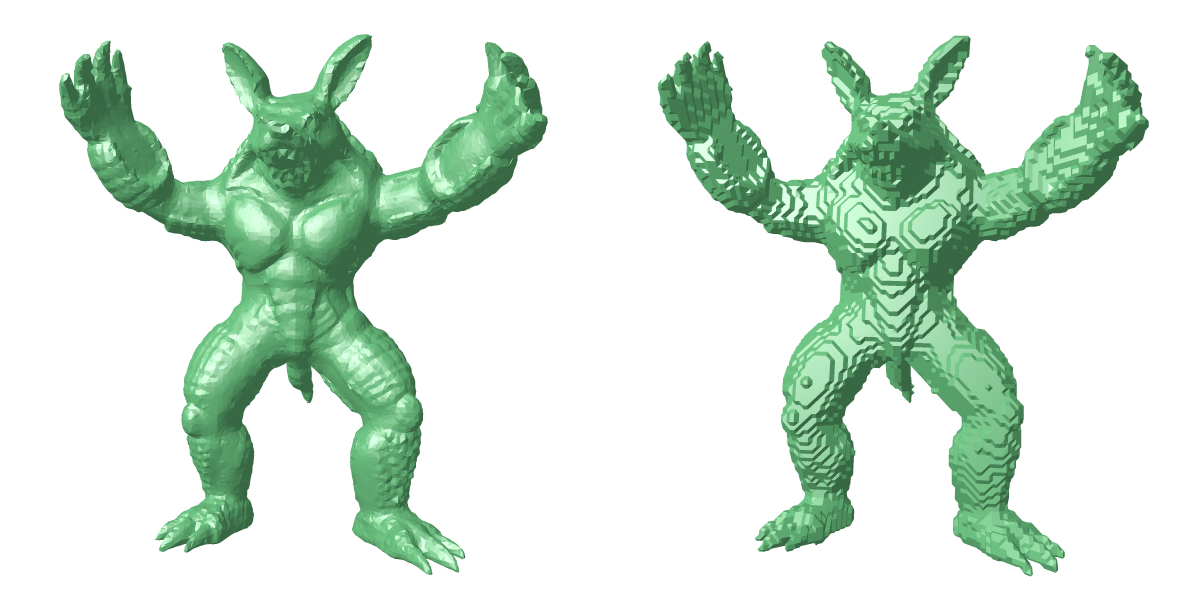

In [1]:
from IPython.display import Image
Image(filename = "../docs/armadillo.png")

### $\textit{Bimba}$

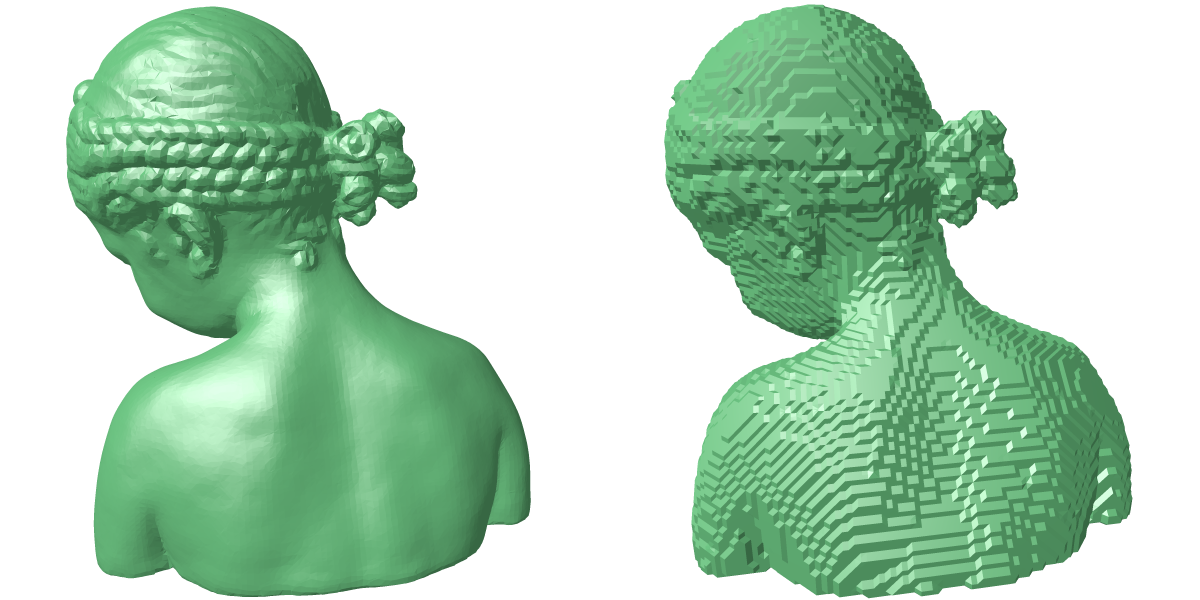

In [2]:
Image(filename = "../docs/bimba.png")

### $\textit{Fandisk}$

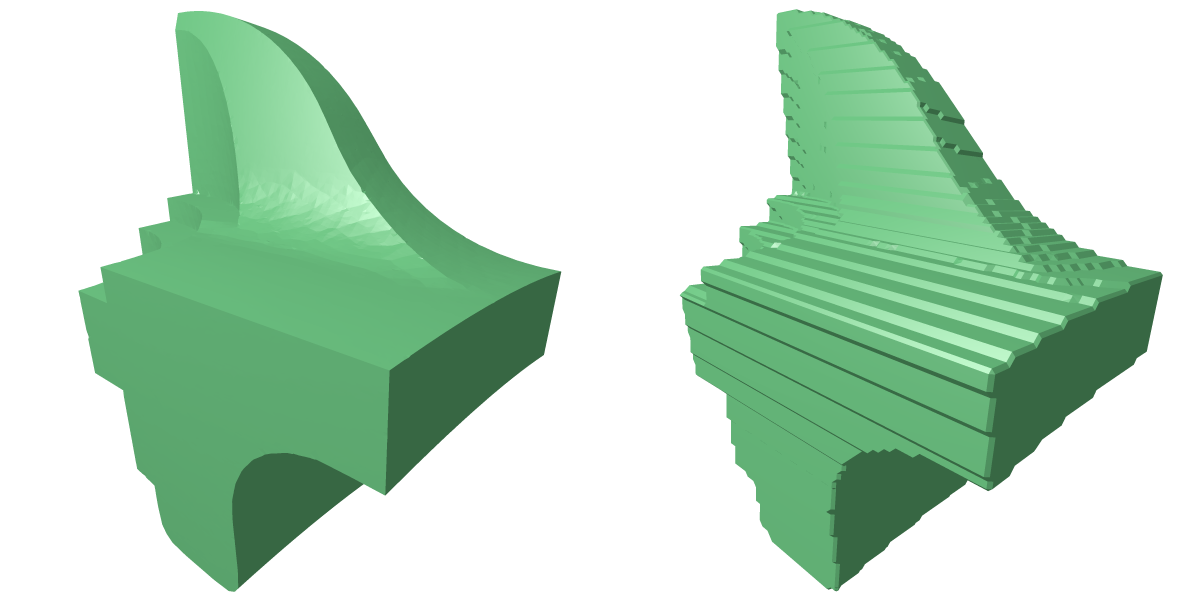

In [3]:
Image(filename = "../docs/fandisk.png")